<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 8: Machine Learning Pipelines</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [1]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

In [2]:
df1 = pd.read_csv('cc_df_group1_version2.csv')
df1.head()

,lat,long,city_pop,trans_date,amt,is_fraud,merch_lat,merch_long,trans_day,city_Angeles City,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
0,14.5958,120.9772,23088000,2020-09-13,966.24,1,14.133430,121.223118,13,0,...,1,0,1,0,0,1,0,0,0,1
1,14.5958,120.9772,23088000,2020-09-13,275.37,1,15.290354,120.246084,13,0,...,0,0,1,0,0,1,0,0,0,1
2,14.5958,120.9772,23088000,2020-09-14,326.96,1,15.402101,121.332516,14,0,...,0,0,1,0,0,1,0,0,0,1
3,14.5958,120.9772,23088000,2020-09-14,1047.59,1,15.166276,121.955649,14,0,...,0,0,1,0,0,1,0,0,0,1
4,14.5958,120.9772,23088000,2020-09-14,286.34,1,15.149144,121.696662,14,0,...,0,0,1,0,0,1,0,0,0,1


In [3]:
to_drop = ['trans_date']

df = df1.drop(to_drop, axis=1)


In [4]:
df.columns

Index(['lat', 'long', 'city_pop', 'amt', 'is_fraud', 'merch_lat', 'merch_long',
       'trans_day', 'city_Angeles City', 'city_Antipolo',
       ...
       'part_of_day_lunch', 'region_CALABARZON', 'region_NCR',
       'region_Region 3', 'quarantine_status_ECQ', 'quarantine_status_GCQ',
       'quarantine_status_MECQ', 'quarantine_status_Normal', 'QL_Extreme QL',
       'QL_Moderate-Low QL'],
      dtype='object', length=242)

Would Recommend:       0
1    300
0  29677
Proportion Chance Criterion: 98.02%
1.25 * Proportion Chance Criterion: 122.52%


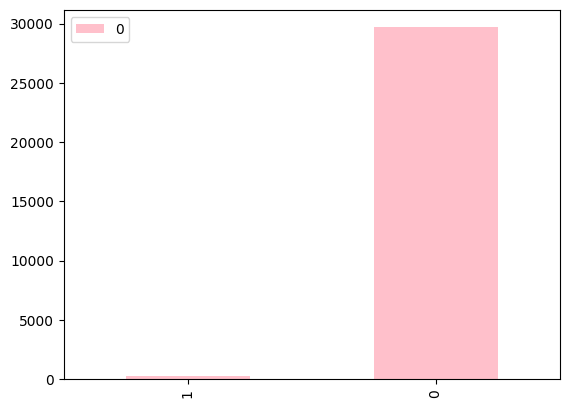

In [5]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [6]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y) #maintain the proportion of your class

#ideal is to use train -> validation -> test/holdout
#train - > validation : used to check overfitting

#if namake sure na di overfitting, you can use the model to your hold out

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [7]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None): #codify: save everything into a function #cv is cross validation 
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time() #used to compute total run time of process

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling for every iteraction
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]


#output: two data frames; one for plotting and one to pretify data frame

# Steps:
    1. Baseline scores
        -without resampling 
    2. Run resampling techniques
        -oversampling
        -undersampling
    3. Identify the model with resampling (i.e. Random Forest x SMOTE)
    4. Hypertune themodel with resampling (gridsearch)
    
 high performance x runtime x no overfitting

### Baseline

In [8]:
#baseline score is score without applying resampling

models_dict = {
              'LogisticRegression': LogisticRegression(random_state=143)}

# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [9]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,2.083638,99.38%,40.22%,99.28%,32.00%


### Applying resampling techniques

#### Oversampling

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.8150055408477783
Resampling done in 0.22547197341918945
Resampling done in 0.17911767959594727
Resampling done in 0.14198875427246094
Resampling done in 0.15629243850708008


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,1.837188,96.60%,97.83%,95.16%,79.56%


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.26259565353393555
Resampling done in 0.20572805404663086
Resampling done in 0.2120192050933838
Resampling done in 0.19292449951171875
Resampling done in 0.18324494361877441


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,1.629366,96.47%,98.15%,94.68%,81.33%


----------------------------------------------BorderlineSMOTE----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.21946954727172852
Resampling done in 0.2012639045715332
Resampling done in 0.18851494789123535
Resampling done in 0.17865443229675293
Resampling done in 0.2040693759918213


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,1.794193,97.28%,98.35%,95.95%,76.89%


-------------------------------------------------SVMSMOTE--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 3.3244128227233887
Resampling done in 9.622299909591675
Resampling done in 17.77717399597168
Resampling done in 14.96377944946289
Resampling done in 3.872436046600342


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,1.987242,97.87%,98.33%,97.22%,74.67%


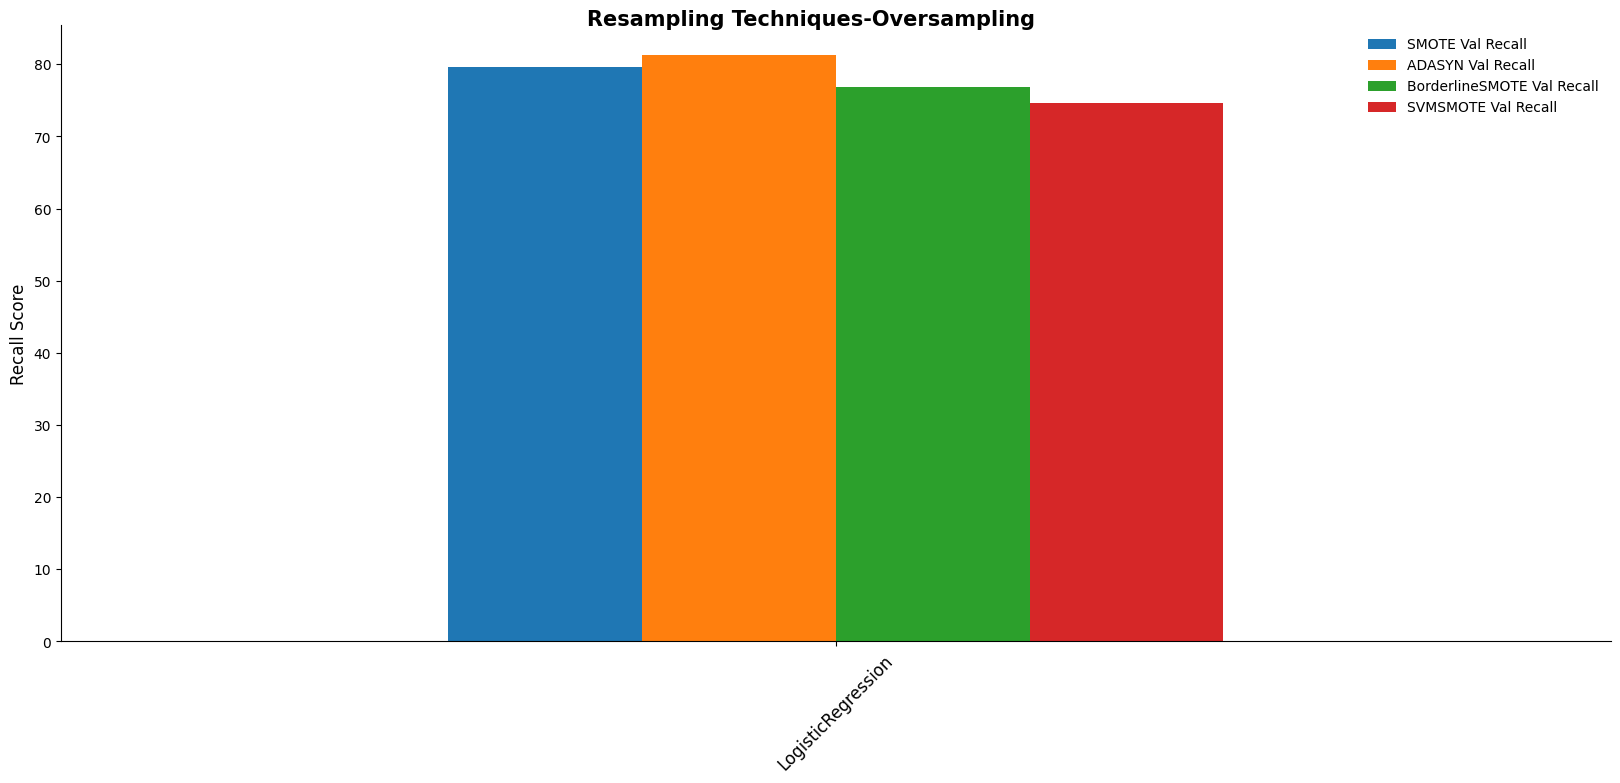

In [10]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN()),('BorderlineSMOTE', BorderlineSMOTE()),('SVMSMOTE', SVMSMOTE())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over['BorderlineSMOTE Val Recall'] = outputs[2]['Val Recall']
ps_over['SVMSMOTE Val Recall'] = outputs[3]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [11]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss()),('EditedNearestNeighbours', EditedNearestNeighbours()),('AllKNN', AllKNN())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 3.9438130855560303
Resampling done in 3.5826809406280518
Resampling done in 3.592317819595337
Resampling done in 3.725853443145752
Resampling done in 4.409320116043091


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,2.390545,99.38%,40.33%,99.28%,32.00%


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 4.6530702114105225
Resampling done in 1.0212326049804688
Resampling done in 0.5351221561431885
Resampling done in 0.8627161979675293
Resampling done in 0.5773634910583496


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,0.087848,87.06%,79.22%,52.04%,77.33%


------------------------------------------EditedNearestNeighbours------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.9671077728271484
Resampling done in 1.647951364517212
Resampling done in 1.4983370304107666
Resampling done in 1.4673311710357666
Resampling done in 1.543661117553711


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,0.932405,99.38%,40.78%,99.28%,32.00%


--------------------------------------------------AllKNN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 3.9960713386535645
Resampling done in 7.899340867996216
Resampling done in 10.364962816238403
Resampling done in 9.87842607498169
Resampling done in 9.829288244247437


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
LogisticRegression,2.067579,99.38%,40.67%,99.28%,32.44%


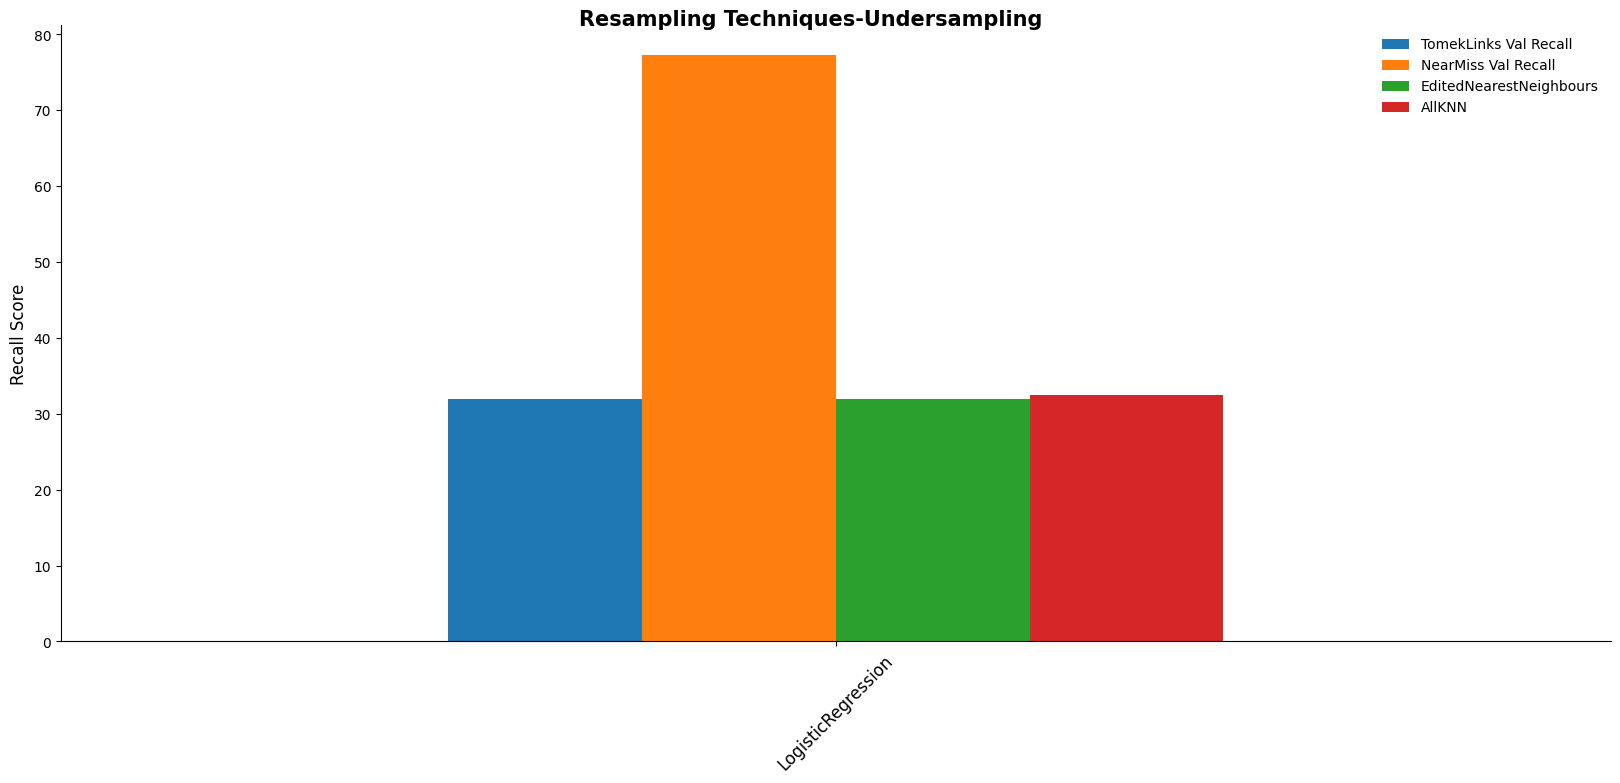

In [12]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under['EditedNearestNeighbours'] = outputs_u[2]['Val Recall']
ps_under['AllKNN'] = outputs_u[3]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [13]:
#Grid search iterates all combination of your paramaters
#Randomized Search CV what would be the random combination of the variables that I would need to try to get the best 
    #(need to input number of iteration; different combination yung gagawin niya per iteration)

def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Logistic Regression and apply ADASYN()"""
    params = {'C': [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1]
              }
    new_params = {'logisticregression__' +   #make sure to properly state this (model you are trying)
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      LogisticRegression(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      LogisticRegression(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10) #verbose = 10 means you can see the whole picture of each iteration; if 1 ang makikita lang ay "fitting 120 fits"
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['LogisticRegression', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline #not the hypertuned result
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['LogisticRegression', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [14]:
#Oversampling: ADASYN

start_time = time.time()
rf_tmk_rec = train_rf(X_trainval, y_trainval, 'recall', ADASYN(),
                       hypertune=True, resample=True)
start_time = time.time()
rf_tmk_acc = train_rf(X_trainval, y_trainval, 'accuracy', ADASYN(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START logisticregression__C=1e-08.................................
[CV 1/5; 1/8] END logisticregression__C=1e-08;, score=(train=1.000, test=1.000) total time=   1.8s
[CV 2/5; 1/8] START logisticregression__C=1e-08.................................
[CV 2/5; 1/8] END logisticregression__C=1e-08;, score=(train=0.983, test=0.978) total time=   0.7s
[CV 3/5; 1/8] START logisticregression__C=1e-08.................................
[CV 3/5; 1/8] END logisticregression__C=1e-08;, score=(train=0.000, test=0.000) total time=   0.6s
[CV 4/5; 1/8] START logisticregression__C=1e-08.................................
[CV 4/5; 1/8] END logisticregression__C=1e-08;, score=(train=0.972, test=0.956) total time=   0.5s
[CV 5/5; 1/8] START logisticregression__C=1e-08.................................
[CV 5/5; 1/8] END logisticregression__C=1e-08;, score=(train=1.000, test=1.000) total time=   0.4s
[CV 1/5; 2/8] START logisticregression__

[CV 1/5; 2/8] END logisticregression__C=1e-05;, score=(train=0.724, test=0.722) total time=   0.6s
[CV 2/5; 2/8] START logisticregression__C=1e-05.................................
[CV 2/5; 2/8] END logisticregression__C=1e-05;, score=(train=0.740, test=0.738) total time=   0.6s
[CV 3/5; 2/8] START logisticregression__C=1e-05.................................
[CV 3/5; 2/8] END logisticregression__C=1e-05;, score=(train=0.768, test=0.762) total time=   0.5s
[CV 4/5; 2/8] START logisticregression__C=1e-05.................................
[CV 4/5; 2/8] END logisticregression__C=1e-05;, score=(train=0.741, test=0.745) total time=   0.5s
[CV 5/5; 2/8] START logisticregression__C=1e-05.................................
[CV 5/5; 2/8] END logisticregression__C=1e-05;, score=(train=0.736, test=0.734) total time=   0.5s
[CV 1/5; 3/8] START logisticregression__C=0.001.................................
[CV 1/5; 3/8] END logisticregression__C=0.001;, score=(train=0.802, test=0.802) total time=   0.7s
[

In [15]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_rec[0], #name of model
                np.round(rf_tmk_acc[1]*100, 6), #train_accuracy
                np.round(rf_tmk_acc[2]*100, 6), #test accuracy
                np.round(rf_tmk_rec[1]*100, 6), #train recall
                np.round(rf_tmk_rec[2]*100, 6)] #test recall
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_rec[0],
                 '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
LogisticRegression,82.79%,94.67%,90.24%,85.78%


In [16]:
#best model among hypertuned and resampled models
# re-fitting for the holdout 
rh = rf_tmk_rec[-1] #kaya nilalabas yung model is to know yung perf ng mdoel sa hold out data set (dulo kaya -1)
rh.fit(X_trainval, y_trainval) #fit to trainval 
y_preds = rh.predict(X_holdout) #predict using holdout (unseen data)
rh_holdout_score = recall_score(y_holdout, y_preds) 

#### Base-case

In [17]:
#behaviour of model without hypertuning or resampling
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False) 

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [18]:
holdout_score

0.41333333333333333

In [19]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

#dataframe containing all the results

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,40.22%,32.00%,41.33%
Resampling x Hypertune,90.24%,85.78%,84.00%


In [20]:
explainer = shap.TreeExplainer(rh, feature_names=X_holdout.columns)
shap_values = explainer.shap_values(X_holdout) #input should be unseen data
model.predict(X_holdout.loc[[8]])
# find the location
loc_df = X_holdout.reset_index()
loc_df[loc_df['index'] == 8]

Exception: Model type not yet supported by TreeExplainer: <class 'imblearn.pipeline.Pipeline'>